In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import pylab
import cosima_cookbook as cc
session = cc.database.create_session()
from dask.distributed import Client
client = Client(n_workers=28)
client

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32871/status,
Dashboard: /proxy/32871/status,Workers: 7
Total threads: 28,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33935,Workers: 7
Dashboard: /proxy/32871/status,Total threads: 28
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:38659,Total threads: 4
Dashboard: /proxy/38005/status,Memory: 18.29 GiB
Nanny: tcp://127.0.0.1:35865,


In [3]:
session = cc.database.create_session()

In [4]:
experiment = '01deg_jra55v13_ryf9091'
lat_range = slice(-79, -56)

yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean = lat_range)

xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean = lat_range)

xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)

In [5]:
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

In [6]:
start_time = '2170-01-01'
end_time = '2170-12-31'
time_slice = slice(start_time, end_time)
bath = cc.querying.getvar(experiment,'ht', session, n=-1)


bath_mean = bath.sel(yt_ocean = lat_range)

bath_mean
contour_depth = 1000

In [7]:
h = bath_mean.load()

# Fill in land with zeros:
h = h.fillna(0)

In [8]:
grid_sel = 't'
if grid_sel == 'u':
    x_var = xu_ocean
    y_var = yu_ocean
elif grid_sel == 't':
    x_var = xt_ocean
    y_var = yt_ocean

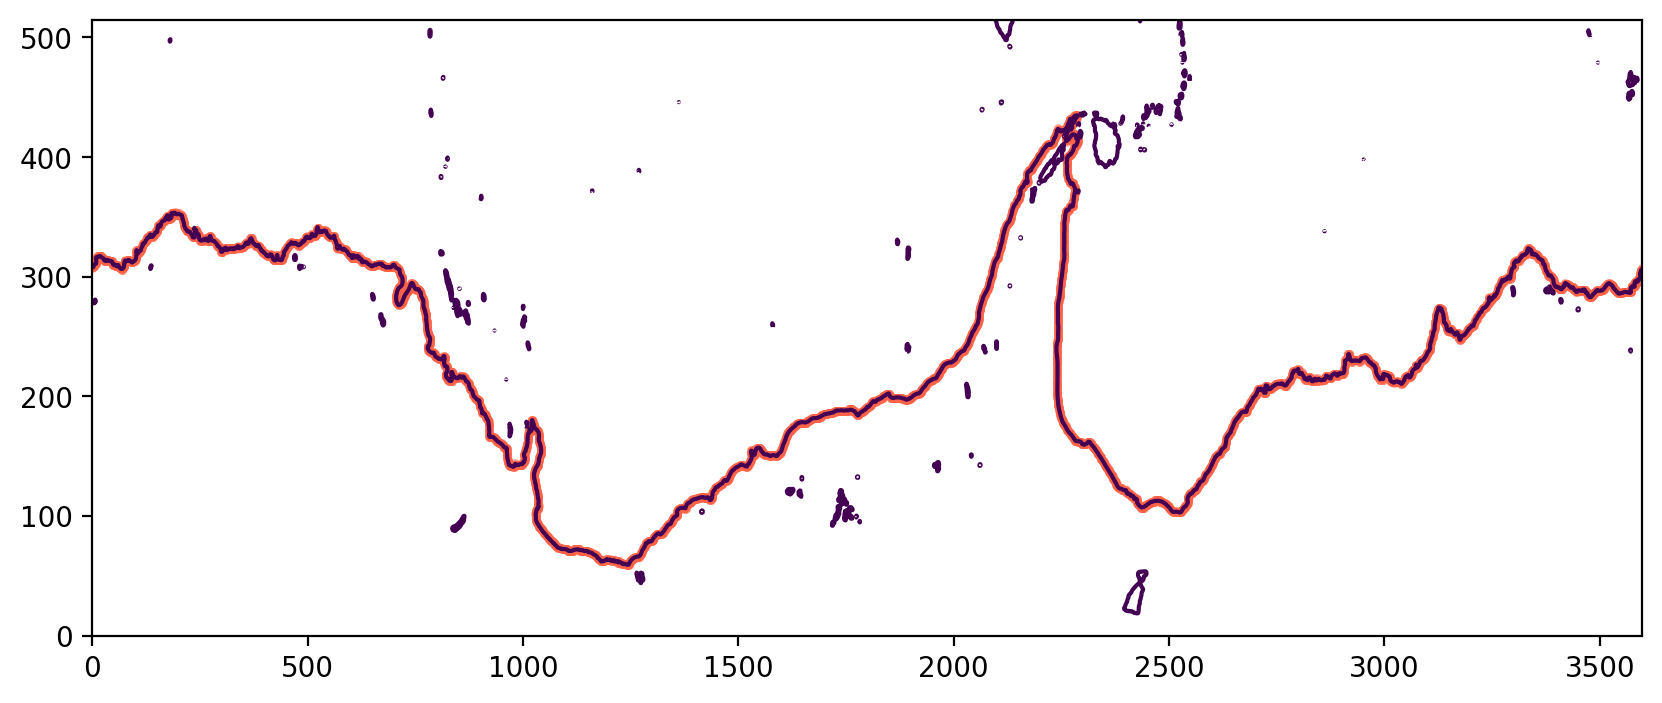

In [10]:
fig = plt.figure(figsize = (10, 4))
count = 1
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count ==  2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [11]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [12]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [13]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

In [14]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]

In [15]:
experiment = '01deg_jra55v13_ryf9091'
UVEL = cc.querying.getvar(experiment, 'u' , session, frequency='1 monthly', n=-40)
UVEL = UVEL.sel({'yu_ocean': lat_range})
VVEL = cc.querying.getvar(experiment, 'v' , session, frequency='1 monthly',n=-40)
VVEL = VVEL.sel({'yu_ocean': lat_range})
dzt = cc.querying.getvar(experiment, 'dzt' , session, frequency='1 monthly',n=-40)
dzt = dzt.sel({'yt_ocean': lat_range})



In [16]:
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).isel({'yu_ocean': slice(0, 494)})

# Calculating yearly mean of U,V
VVELmean = VVEL.groupby('time.year').mean('time').mean('year')
UVELmean = UVEL.groupby('time.year').mean('time').mean('year')
dztmean = dzt.groupby('time.year').mean('time').mean('year')

#Regridding them
import xgcm
print("xgcm version ", xgcm.__version__)
folder = '/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m/wf4500/access-om2/archive/ryf/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords').sel({'yu_ocean':lat_range}).sel({'yt_ocean': lat_range})

ds = xr.merge([UVELmean,VVELmean,dztmean, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X','Y'])

#Weighted mean Along Z
UVELmeanz = ((grid.interp(UVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')
VVELmeanz = ((grid.interp(VVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')




xgcm version  0.8.1


In [17]:
yline=lat_along_contour
xline=lon_along_contour
xline3=np.append(xline[3598]-360,np.append(xline,xline[0:3]+360))
yline3=np.append(yline[3598],np.append(yline,yline[0:3]))

In [18]:
#Next... getting the angle for every 3 points cycle
#first case
# I need to expand the lines by reeating the first few values into the end
#xline2=np.append(xline,xline[0:3])
#yline2=np.append(yline,yline[0:3])
n=0
Fd= 2 #distance of pointe used to calculate the angle
x0=xline3[(n):((n+Fd))]
x1=xline3[((n) +1):((n+1+Fd))]
x2=xline3[((n) +2):((n+2+Fd))]
y0=yline3[(n):((n+Fd))]
y1=yline3[((n)+1):((n+1+Fd))]
y2=yline3[((n)+2):((n+2+Fd))]
angle0 = np.rad2deg(np.arctan2(y0[-1] - y0[0], x0[-1] - x0[0]))
angle1 = np.rad2deg(np.arctan2(y1[-1] - y1[0], x1[-1] - x1[0]))
angle2 = np.rad2deg(np.arctan2(y2[-1] - y2[0], x2[-1] - x2[0]))
for n in range(1,4475):
    x0=xline3[(n):((n+Fd))]
    x1=xline3[((n) +1):((n+1+Fd))]
    x2=xline3[((n) +2):((n+2+Fd))]
    y0=yline3[(n):((n+Fd))]
    y1=yline3[((n)+1):((n+1+Fd))]
    y2=yline3[((n)+2):((n+2+Fd))]
    
    t0 = np.rad2deg(np.arctan2(y0[-1] - y0[0], x0[-1] - x0[0]))
    t1 = np.rad2deg(np.arctan2(y1[-1] - y1[0], x1[-1] - x1[0]))
    t2 = np.rad2deg(np.arctan2(y2[-1] - y2[0], x2[-1] - x2[0]))
    angle0=np.append(angle0,t0)
    angle1=np.append(angle1,t1)
    angle2=np.append(angle2,t2)
    
anglei_iso = (angle0+angle1)/2

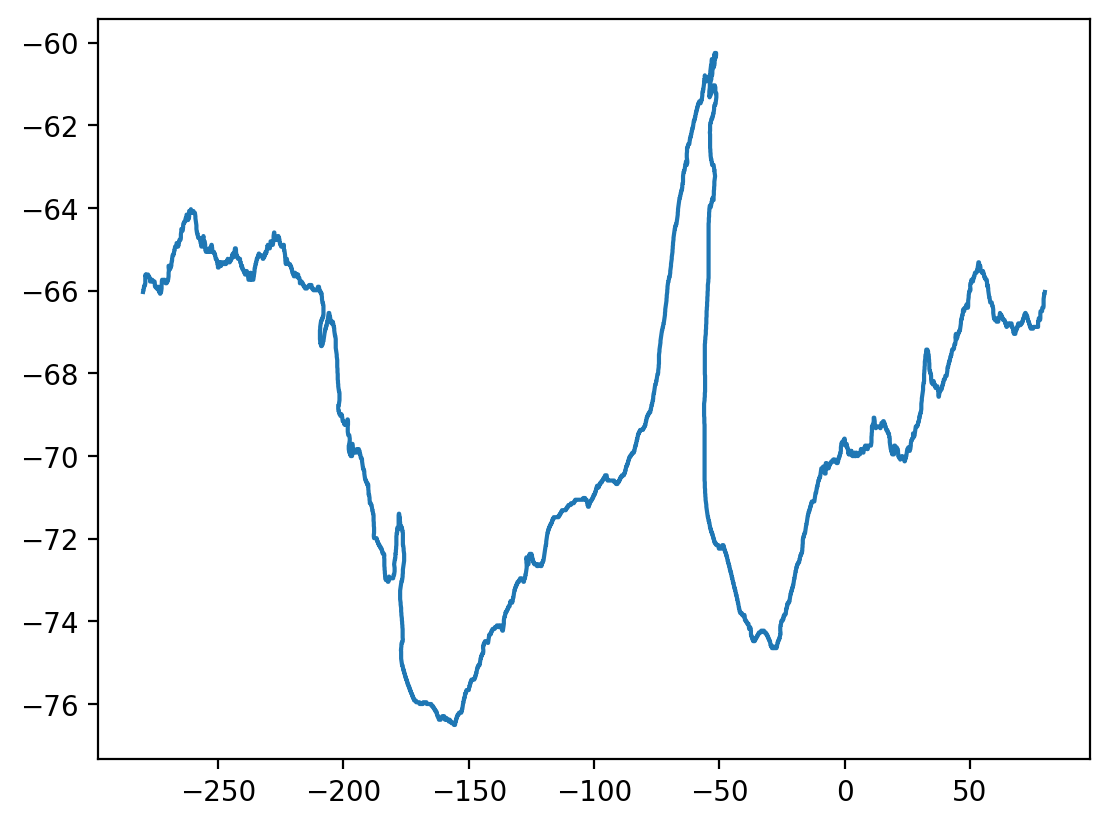

In [19]:
plt.plot(xline,yline,label='1000m isobath')

Text(0.5, 1.0, 'Degree values plotted over contour')

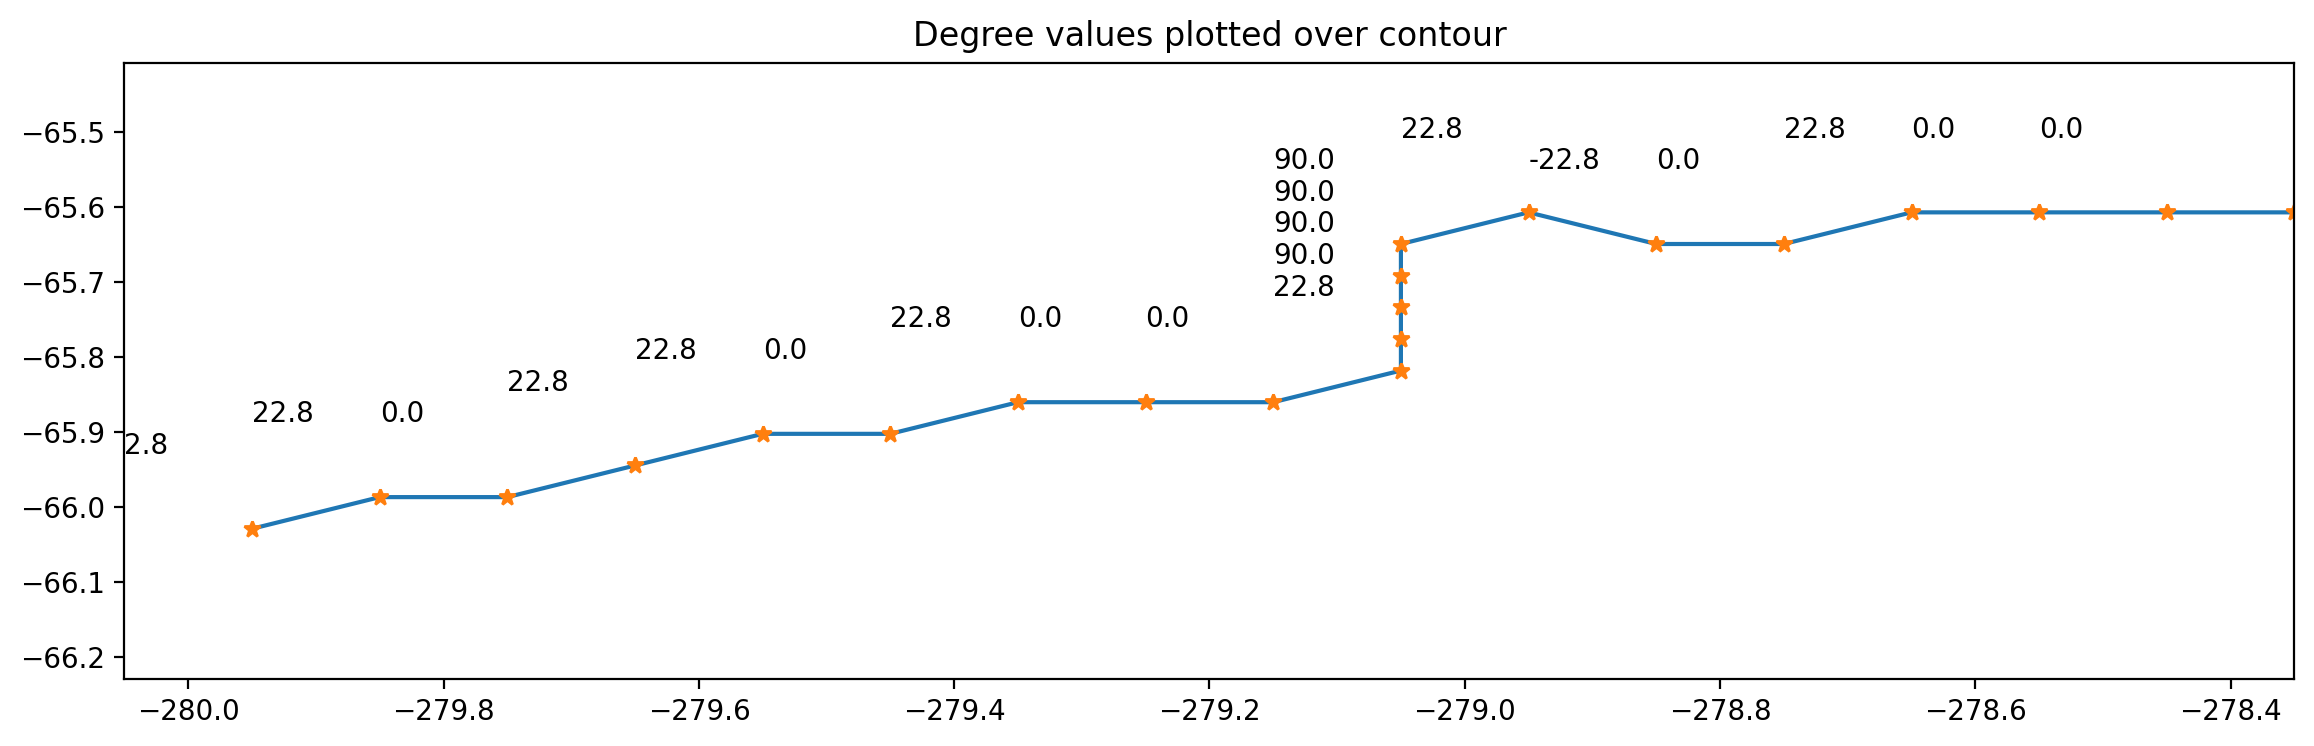

In [27]:
# I need to test if these angles make sense. lets make some plots at specific places
#plt.plot(anglei_iso)
fig = plt.figure(figsize = (14, 4))
uplimitoplot=20 #AP=3050
lowlimitoplot=0 #AP=2610
plt.plot(xline,yline,label='1000m isobath')
plt.plot(xline,yline,'*',label='1000m isobath')

# #plt.plot(xline,yline8000m)
for n in range(lowlimitoplot,uplimitoplot):
    plt.text(xline[n]-0.1,yline[n]+0.1,str(str(int(angle0[n]*10)/10)),clip_on=True)
             
plt.xlim(xline[lowlimitoplot]-0.1,xline[uplimitoplot])
plt.ylim(np.min(yline[lowlimitoplot:uplimitoplot])-0.2,
         np.max(yline[lowlimitoplot:uplimitoplot])+0.2)
plt.title('Degree values plotted over contour')
# lowlimitoplot]xline[uplimitoplot]plt.legend()
#Ok, it seems to get the right angle. But noe I have to figure out, 
#how do I apply that to the  data? THe way it is I can use the 
#index to apply in the same exact points. 
#But I need to have a mask to apply outside the points.

In [ ]:
Y, X = np.meshgrid(xt_ocean, yt_ocean)

array([[-78.99666396, -78.99666396, -78.99666396, ..., -78.99666396,
        -78.99666396, -78.99666396],
       [-78.9544246 , -78.9544246 , -78.9544246 , ..., -78.9544246 ,
        -78.9544246 , -78.9544246 ],
       [-78.91218525, -78.91218525, -78.91218525, ..., -78.91218525,
        -78.91218525, -78.91218525],
       ...,
       [-56.14044297, -56.14044297, -56.14044297, ..., -56.14044297,
        -56.14044297, -56.14044297],
       [-56.08468661, -56.08468661, -56.08468661, ..., -56.08468661,
        -56.08468661, -56.08468661],
       [-56.02884958, -56.02884958, -56.02884958, ..., -56.02884958,
        -56.02884958, -56.02884958]])

In [111]:
#plt.plot(np.diff(yt_ocean))
yt_ocean2=np.arange(np.array(yt_ocean[0]),np.array(yt_ocean[-1]),np.diff(yt_ocean[364:366]))
np.shape(yt_ocean2)

(516, 3600)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  retu

ValueError: applied function returned data with unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names: ()

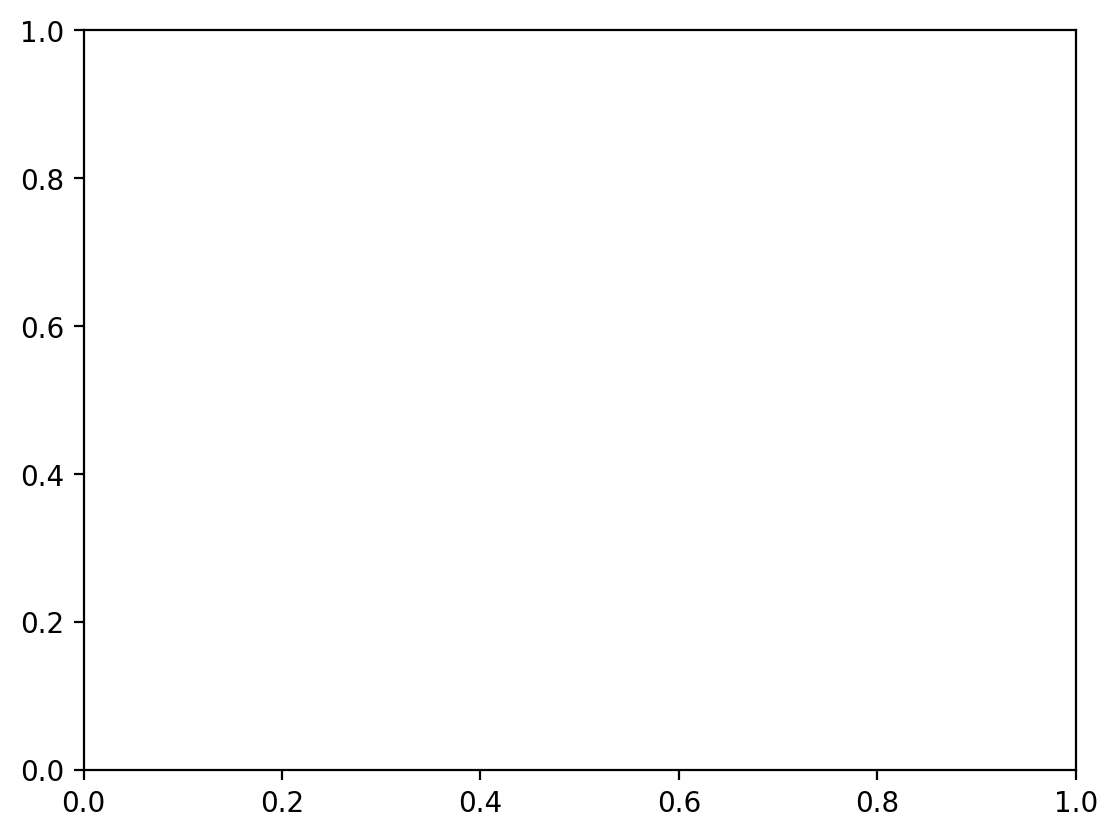

In [114]:
# Create streamline figure
import plotly.figure_factory as ff
plt.streamplot(xt_ocean, yt_ocean2, UVELmeanz, VVELmeanz)